# Multilingual Digital Story Grammar

In this notebook, we aim to implement a version of Digital Story Grammar (DSG; Bastholm Andrade & Andersen; [link](https://www.tandfonline.com/doi/abs/10.1080/13645579.2020.1723205)) that works with multiple languages (in particular Dutch, German, Danish, and English). The code will interface to the spaCy NLP library that has pretrained and easy-to-use pipelines for many languages available.

The goal of the method is to extract the subject (actor), main verb (action), and object of each sentence or phrase. In DSG, these are referenced as *narrative units* and enable the construction of character networks. This notebook will use spaCy's `DependencyMatcher` to extract patterns in dependency relations of each sentence. However, each language has somewhat different dependency relations so it requires a specific set of patterns to be matched. German in particular uses a completely different notation for dependency relations, so it requires entirely different patterns that the other three languages (see this [link](https://www.ims.uni-stuttgart.de/documents/ressourcen/korpora/tiger-corpus/annotation/tiger_scheme-syntax.pdf) for the notation scheme). 

The patterns for each language are store in a separate `multilingual_dsg_patterns_xx.json` file. The pattern files consist of a nested list of dictionaries `[[{}, {}, ...], ...]`. Each list of dictionaries `[{},{}, ...]` represents a pattern of dependency relations that will be matched. Each dictionary in the list represents a token that is part of the dependency relations pattern. The first dictionary in each pattern has usually two entries: `RIGHT_ID` indicating a name for the token in the pattern; and `RIGHT_ATTRS` listing the required attributes of the token for a match (e.g., `{"DEP": "nsubj"}` means that the token must be a subject in a phrase). There can be `OR` or `NOT` type matches by using `IN` or `NOT_IN` keys for dictionaries (see the pattern files for examples). Subsequent dictionaries in a pattern have two additional entries: `LEFT_ID` which refers to another token in the parsing tree to which the current token is related; and `REL_OP` specifying the relation between the other token and the token to be matched. An overview of possible relations is presented on https://spacy.io/api/dependencymatcher. For example `REL_OP: >` indicates a match when the `LEFT_ID` token is the head of the `RIGHT_ID` token in the parsing tree.

Example:
```
[
  {
    "RIGHT_ID": "verb",
    "RIGHT_ATTRS": {"POS": {"IN": ["VERB", "AUX"]}}
  },
  {
    "LEFT_ID": "verb",
    "REL_OP": ">",
    "RIGHT_ID": "subj",
    "RIGHT_ATTRS": {"DEP": "nsubj"}
  },
  {
     "LEFT_ID": "verb",
     "REL_OP": ">>",
     "RIGHT_ID": "obj",
     "RIGHT_ATTRS": {"DEP": "pobj"}
  }
]

if a word has POS tag VERB or AUX and
   the word has an immediate dependent (DEP) word with relation nsubj and
   the word has a dependent (DEP) word with relation pobj 
then word1 is a verb, word2 is a subj and word3 is an obj 
```

A sentence or phrase can have multiple matches for a pattern (i.e., multiple objects or conjuncts), and for each match a row is added to the output table.

A step-by-step example can also be found on https://spacy.io/api/dependencymatcher.

In [1]:
""" Multilingual Digital Story Grammar """

import os
import json
import spacy
import numpy as np
import pandas as pd
import networkx as nx
import warnings
# Change this to use different language as example; see spacy.io/models
from spacy.lang.en.examples import sentences as en_sentences
from spacy.lang.nl.examples import sentences as nl_sentences
from spacy.lang.de.examples import sentences as de_sentences
from spacy.lang.da.examples import sentences as da_sentences
from spacy.matcher import DependencyMatcher
from spacy import displacy

if spacy.__version__ < "3":
    warnings.warn(
        "Module 'spacy' should be version >= 3.0 to run this notebook without errors")
if pd.__version__ < "1.0":
    warnings.warn(
        "Module 'pandas' should be version >= 1.0 to run this notebook without errors")


2022-06-21 14:05:22.603352: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-21 14:05:22.603389: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
EN_SPACY_PIPELINE = "en_core_web_sm"
EN_DEPENDENCY_PATTERN_FILE = "multilingual_dsg_patterns_en.json"

NL_SPACY_PIPELINE = "nl_core_news_sm"
NL_DEPENDENCY_PATTERN_FILE = "multilingual_dsg_patterns_nl.json"

DE_SPACY_PIPELINE = "de_core_news_sm"
DE_DEPENDENCY_PATTERN_FILE = "multilingual_dsg_patterns_de.json"

DA_SPACY_PIPELINE = "da_core_news_sm"
DA_DEPENDENCY_PATTERN_FILE = "multilingual_dsg_patterns_da.json"


In [3]:
# Define a few test sentences
examples = [
    "The bird flew over the roof.",
    "The cow ate the grass. The goat watched the cow.",
    "The cow ate the grass while the goat watched the cow.",
    "The goat watched the cow which was eating grass.",
    "The goat attempted eating the cow's grass.",
    "The cow ate grass, the cow ate butter.",
    "The cow and the goat ate grass.",
    "The grass was eaten by the cow, the goat and the bird."
]


In [4]:
def load_spacy_pipeline(name):
    """Check if the spacy language pipeline was downloaded and load it.
    Downloads the language pipeline if not available.

    Args:
        name (string): Name of the spacy language.

    Returns:
        spacy.language.Language: The spacy language pipeline
    """
    if spacy.util.is_package(name):
        nlp = spacy.load(name)
    else:
        os.system(f"spacy download {name}")
        nlp = spacy.load(name)
    return nlp


In [5]:
def check_dict_in_list(dict_obj, dict_list):
    """Check if a dictionary (partially) matches a list of dictionaries.

    Note: This function is used to avoid duplicate matches (e.g., Subj+Verb in Subj+Verb+Obj)

    Args:
        dict_obj (dict): A dictionary object.
        dict_list (list): A list of dictionary objects.

    Returns:
        bool: True if all non-empty items in dict_obj match the items in any dictionary objects in dict_list, otherwise False.
    """
    if dict_obj in dict_list:
        return True

    check = [False] * len(dict_obj.keys())

    for i, key in enumerate(dict_obj.keys()):
        if str(dict_obj[key]) == "_":
            check[i] = True
            next
        else:
            for ref_dict in dict_list:
                if dict_obj[key].i == ref_dict[key].i:
                    check[i] = True
                    break

    return all(check)


In [6]:
def extract_matches(doc, matches, matcher, nlp, keys):
    """Extract the matched tokens for selected keys.

    Args:
        doc (spacy.tokens.Doc): A spacy doc object as returned by a spacy language pipeline.
        matches (list): A list of (match_id, token_ids) tuples as returned by a spacy dependency matcher.
        matcher (spacy.matcher.DependencyMatcher): A spacy dependency matcher object.
        nlp (spacy.language.Language): A spacy language pipeline.
        keys (list): A list of keys to which the dependcy matches are assigned.

    Returns:
        list: A list of dictionaries that each contain a match of the dependency matcher. 
            Has the same keys as the `keys` argument. Empty keys contain a spacy token with text='_'.
    """
    matches_list = []

    for l, (match_id, token_ids) in enumerate(matches):
        match_dict = {}

        for key in keys:
            match_dict[key] = nlp("_")[0]
            
        for k, token_id in enumerate(token_ids):
            key = matcher.get(match_id)[1][0][k]["RIGHT_ID"]
            if key in match_dict.keys():
                match_dict[key] = doc[token_id]

        if not check_dict_in_list(match_dict, matches_list):
            match_dict["match_id"] = match_id
            matches_list.append(match_dict)

    return matches_list


In [7]:
def create_matcher(nlp, pattern_file):
    """Create a spacy dependency matcher.

    Args:
        nlp (spacy.language.Language): A spacy language pipeline.
        pattern_file (str): The path to the dependency pattern .json file for the matcher.

    Returns:
        spacy.matcher.DependencyMatcher: A spacy dependency matcher object.
    """
    matcher = DependencyMatcher(nlp.vocab, validate=True)

    with open(pattern_file, "r") as file:
        patterns = json.load(file)

    for i, pattern in enumerate(patterns):
        matcher.add(i, [pattern])

    return matcher


In [8]:
def append_children_deps(token, doc, children_deps):
    """Append children to a token based on dependency tag.

    Note: This function is used to append words of a noun compound.

    Args:
        token (spacy.token.Token): A spacy token object.
        doc (spacy.token.Doc): A spacy doc object that includes the token.
        children_deps (list): A list of dependency tags.

    Returns:
        spacy.token.Token: A span of spacy tokens (token argument plus children with specified dependency tags) if token argument is non-empty, the token argument otherwise.
    """

    if str(token) != "_":
        children_match_idx = [
            child.i for child in token.children if child.dep_ in children_deps] + [token.i]

        span = doc[min(children_match_idx):max(children_match_idx)+1]

        return span
    else:
        return token


In [9]:
def get_subject_object_verb_table(docs, nlp, matcher, keys=["verb", "subj", "obj", "comp", "prep"]):
    """Construct a pandas dataframe with subjects, verbs, and objects per sentence of documents.

    Args:
        docs (list): A list of text strings.
        nlp (spacy.language.Language): A spacy language pipeline.
        matcher (spacy.matcher.DependencyMatcher): A spacy dependency matcher object.
        keys (list): A list of keys to which the dependency matches are assigned. 
            Defaults to subjects, verbs, and objects.

    Returns:
        pandas.DataFrame: A dataframe with a row for each match of the dependency matcher and cols:
            doc_id (str): Index of the document in the document list.
            sent_id (str): Index of the sentence in the document.
            sent (spacy.tokens.Span): A spacy span object with the sentence.
            match_id (str): Index of the match in the sentence.

            For each key in the `keys` argument:
                key (spacy.tokens.Token): A spacy token object that matches the dependency matcher patterns.
    """
    docs_piped = nlp.pipe(docs)
        
    table_dict = {
        "doc_id": [],
        "sent_id": [],
        "sent": [],
        "match_id": [],
        "subj": [],
        "verb": [],
        "obj": [],
        "comp": [],
        "prep":[],
    }

    for i, doc in enumerate(docs_piped): # i: doc index
        for j, sent in enumerate(doc.sents): # j: sent index
            matches = matcher(sent)
            matches_list = extract_matches(
                sent, matches, matcher, nlp, keys=keys)
            for l, match in enumerate(matches_list): # l: match index
                table_dict["doc_id"].append(str(i))
                table_dict["sent_id"].append(str(j))
                table_dict["sent"].append(sent.text)
                table_dict["match_id"].append(str(match["match_id"]))

                for key in keys:
                    table_dict[key].append(append_children_deps(
                        match[key], doc, ["compound", "flat"]))

                    # Check for conjuncts, and add table row for each
                    for conj in match[key].conjuncts:
                        table_dict["doc_id"].append(str(i))
                        table_dict["sent_id"].append(str(j))
                        table_dict["sent"].append(sent.text)
                        table_dict["match_id"].append(str("?"))
                        table_dict[key].append(conj)
                        for key_conj in keys:
                            if key != key_conj:
                                table_dict[key_conj].append(
                                    match[key_conj])
    for i in range(0, len(table_dict["comp"])):
        # insert table_dict["comp"][i] in table_dict["verb"][i]) here
        pass
    
    return pd.DataFrame(table_dict)


In [10]:
def plot_character_network(sov_table_df):
    """Plots a subject-object-verb table as a character network. The edge weights are the sentiment scores of the verbs.

    Args:
        sov_table_df (pandas.DataFrame): A pandas data frame containing a subject, verb, and object token in each row

    """
    sov_table_df["sentiment"] = pd.Series([verb.sentiment for verb in sov_table_df["verb"]], dtype=float)
    sov_table_df["subj_text"] = pd.Series([subj.text for subj in sov_table_df["subj"]], dtype=str)
    sov_table_df["obj_text"] = pd.Series([obj.text for obj in sov_table_df["obj"]], dtype=str)

    char_net = nx.from_pandas_edgelist(
        sov_table_df,
        source="subj_text",
        target="obj_text",
        edge_attr="sentiment"
    )
    
    nx.draw_networkx(char_net)

In [11]:
def span_to_string(column):
    new_column = []
    for item in column:
        new_column.append(str(item))
    return new_column

In [12]:
def add_verb_group_column(result_table):
    verb_group_column = []
    for i, row in result_table.iterrows():
        verb_group = str(row["verb"])
        if str(row["prep"]) != "_":
            verb_group += " " + str(row["prep"])
        if str(row["comp"]) != "_":
            verb_group += " " + str(row["comp"])
        verb_group_column.append(verb_group)
    result_table["verb group"] = verb_group_column
    del result_table["verb"]
    del result_table["comp"]
    del result_table["prep"]
    result_table = result_table[["doc_id", "sent_id", "sent", "match_id", "subj", "verb group", "obj"]]
    result_table["subj"] = span_to_string(result_table["subj"])
    result_table["obj"] = span_to_string(result_table["obj"])
    return result_table

## English

In [13]:
nlp_en = load_spacy_pipeline(EN_SPACY_PIPELINE)

matcher_en = create_matcher(nlp_en, EN_DEPENDENCY_PATTERN_FILE)

en_sentences

['Apple is looking at buying U.K. startup for $1 billion',
 'Autonomous cars shift insurance liability toward manufacturers',
 'San Francisco considers banning sidewalk delivery robots',
 'London is a big city in the United Kingdom.',
 'Where are you?',
 'Who is the president of France?',
 'What is the capital of the United States?',
 'When was Barack Obama born?']

In [14]:
result_table = get_subject_object_verb_table(en_sentences, nlp_en, matcher_en)

In [15]:
add_verb_group_column(result_table)

,doc_id,sent_id,sent,match_id,subj,verb group,obj
0,0,0,Apple is looking at buying U.K. startup for $1...,3,Apple,looking at buying,U.K.
1,0,0,Apple is looking at buying U.K. startup for $1...,4,Apple,looking,1 billion
2,1,0,Autonomous cars shift insurance liability towa...,0,cars,shift,insurance liability
3,1,0,Autonomous cars shift insurance liability towa...,4,cars,shift,manufacturers
4,2,0,San Francisco considers banning sidewalk deliv...,2,San Francisco,considers banning,delivery robots
5,3,0,London is a big city in the United Kingdom.,4,London,is,United Kingdom
6,4,0,Where are you?,5,you,are,_
7,6,0,What is the capital of the United States?,4,capital,is,United States
8,7,0,When was Barack Obama born?,5,Barack Obama,born,_


   doc_id sent_id                                               sent match_id  \
0       0       0                       The bird flew over the roof.        4   
1       1       0                             The cow ate the grass.        0   
2       1       1                          The goat watched the cow.        0   
3       2       0  The cow ate the grass while the goat watched t...        0   
4       2       0  The cow ate the grass while the goat watched t...        0   
5       2       0  The cow ate the grass while the goat watched t...        2   
6       3       0   The goat watched the cow which was eating grass.        0   
7       3       0   The goat watched the cow which was eating grass.        0   
8       4       0         The goat attempted eating the cow's grass.        2   
9       5       0             The cow ate grass, the cow ate butter.        0   
10      5       0             The cow ate grass, the cow ate butter.        0   
11      5       0           

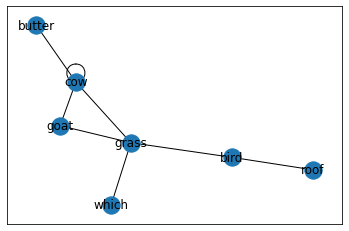

In [16]:
sov_table_en = get_subject_object_verb_table(examples, nlp_en, matcher_en)
print(sov_table_en)
plot_character_network(sov_table_en)

## Dutch

In [17]:
nlp_nl = load_spacy_pipeline(NL_SPACY_PIPELINE)

matcher_nl = create_matcher(nlp_nl, NL_DEPENDENCY_PATTERN_FILE)

nl_sentences

['Apple overweegt om voor 1 miljard een U.K. startup te kopen',
 "Autonome auto's verschuiven de verzekeringverantwoordelijkheid naar producenten",
 'San Francisco overweegt robots op voetpaden te verbieden',
 'Londen is een grote stad in het Verenigd Koninkrijk']

In [18]:
get_subject_object_verb_table(nl_sentences, nlp_nl, matcher_nl)

,doc_id,sent_id,sent,match_id,subj,verb,obj,comp,prep
0,0,0,Apple overweegt om voor 1 miljard een U.K. sta...,0,(Apple),(overweegt),"(U.K., startup)",_,_
1,0,0,Apple overweegt om voor 1 miljard een U.K. sta...,2,(Apple),(overweegt),(miljard),(kopen),_
2,1,0,Autonome auto's verschuiven de verzekeringvera...,0,"(Autonome, auto's)",(verschuiven),(verzekeringverantwoordelijkheid),_,_
3,1,0,Autonome auto's verschuiven de verzekeringvera...,3,"(Autonome, auto's)",(verschuiven),(producenten),_,_
4,2,0,San Francisco overweegt robots op voetpaden te...,3,"(San, Francisco)",(overweegt),(voetpaden),_,_
5,3,0,Londen is een grote stad in het Verenigd Konin...,5,(Londen),(is),(stad),_,_


In [19]:
displacy.render(nlp_nl(nl_sentences[0]), style="dep", options={"distance": 90})

## German

In [20]:
nlp_de = load_spacy_pipeline(DE_SPACY_PIPELINE)

matcher_de = create_matcher(nlp_de, DE_DEPENDENCY_PATTERN_FILE)

de_sentences

['Die ganze Stadt ist ein Startup: Shenzhen ist das Silicon Valley für Hardware-Firmen',
 'Wie deutsche Startups die Technologie vorantreiben wollen: Künstliche Intelligenz',
 'Trend zum Urlaub in Deutschland beschert Gastwirten mehr Umsatz',
 'Bundesanwaltschaft erhebt Anklage gegen mutmaßlichen Schweizer Spion',
 'San Francisco erwägt Verbot von Lieferrobotern',
 'Autonome Fahrzeuge verlagern Haftpflicht auf Hersteller',
 'Wo bist du?',
 'Was ist die Hauptstadt von Deutschland?']

In [21]:
get_subject_object_verb_table(de_sentences, nlp_de, matcher_de)

,doc_id,sent_id,sent,match_id,subj,verb,obj,comp,prep
0,0,0,Die ganze Stadt ist ein Startup: Shenzhen ist ...,0,(Stadt),(ist),(Startup),_,_
1,0,0,Die ganze Stadt ist ein Startup: Shenzhen ist ...,1,(Shenzhen),(ist),_,_,_
2,0,0,Die ganze Stadt ist ein Startup: Shenzhen ist ...,1,(Valley),(ist),_,_,_
3,1,0,Wie deutsche Startups die Technologie vorantre...,0,(Startups),(wollen),(Technologie),_,_
4,2,0,Trend zum Urlaub in Deutschland beschert Gastw...,0,(Trend),(beschert),(Gastwirten),_,_
5,2,0,Trend zum Urlaub in Deutschland beschert Gastw...,0,(Trend),(beschert),(Umsatz),_,_
6,3,0,Bundesanwaltschaft erhebt Anklage gegen mutmaß...,0,(Bundesanwaltschaft),(erhebt),(Anklage),_,_
7,3,0,Bundesanwaltschaft erhebt Anklage gegen mutmaß...,2,(Bundesanwaltschaft),(erhebt),(Spion),_,_
8,4,0,San Francisco erwägt Verbot von Lieferrobotern,0,(Francisco),(erwägt),(Verbot),_,_
9,5,0,Autonome Fahrzeuge verlagern Haftpflicht auf H...,0,(Fahrzeuge),(verlagern),(Haftpflicht),_,_


In [22]:
displacy.render(nlp_de(de_sentences[0]), style="dep", options={"distance": 75})

When looking at the results of the dependency matcher and the parsing tree, it can be seen that the parser makes a few mistakes: In the first sentence, it erroneously labels "Silicon Valley" as a subject.

## Danish

In [23]:
nlp_da = load_spacy_pipeline(DA_SPACY_PIPELINE)

matcher_da = create_matcher(nlp_da, DA_DEPENDENCY_PATTERN_FILE)

da_sentences

['Apple overvejer at købe et britisk startup for 1 milliard dollar.',
 'Selvkørende biler flytter forsikringsansvaret over på producenterne.',
 'San Francisco overvejer at forbyde udbringningsrobotter på fortovet.',
 'London er en storby i Storbritannien.',
 'Hvor er du?',
 'Hvem er Frankrings president?',
 'Hvad er hovedstaden i USA?',
 'Hvornår blev Barack Obama født?']

In [24]:
get_subject_object_verb_table(da_sentences, nlp_da, matcher_nl)

,doc_id,sent_id,sent,match_id,subj,verb,obj,comp,prep
0,0,0,Apple overvejer at købe et britisk startup for...,0,(Apple),(overvejer),(købe),_,_
1,0,0,Apple overvejer at købe et britisk startup for...,0,(Apple),(overvejer),(startup),_,_
2,1,0,Selvkørende biler flytter forsikringsansvaret ...,3,(biler),(flytter),(producenterne),_,_
3,2,0,San Francisco overvejer at forbyde udbringning...,0,(San),(overvejer),(forbyde),_,_
4,2,0,San Francisco overvejer at forbyde udbringning...,0,(San),(overvejer),(udbringningsrobotter),_,_
5,2,0,San Francisco overvejer at forbyde udbringning...,0,(Francisco),(overvejer),(forbyde),_,_
6,2,0,San Francisco overvejer at forbyde udbringning...,3,(San),(overvejer),(fortovet),_,_
7,3,0,London er en storby i Storbritannien.,5,(London),(er),(storby),_,_
8,5,0,Hvem er Frankrings president?,5,(Hvem),(er),(president),_,_
9,7,0,Hvornår blev Barack Obama født?,4,"(Barack, Obama)",(født),_,_,_


In [25]:
displacy.render(nlp_da(da_sentences[2]), style="dep", options={"distance": 120})

The Danish parser also makes a few mistakes: For example, in the second sentence it labels both "San" and "Francisco" as separate subjects.